## EC2401 FINAL PROJECT

### "What distinct factors predominantly influence wellbeing in developed and underdeveloped nations, and how do these determinants diverge between these two categories of countries?"
#### Author - Tarick Akpan
#### Candidate Number - 2302137

#

### Preliminary Thoughts

#### Datasets used and relevant predictions:

1) Happiness: This is our primary dependent variable and represents the wellbeing of a country's citizens. The Happiness Score might be influenced by various factors, including economic, social, and environmental factors. It's possible that different factors are more influential in developed versus underdeveloped countries.

2) GDP: Generally, it's assumed that higher GDP correlates with better living conditions, more services, and thus, higher happiness. However, there might be diminishing returns in developed countries, while in underdeveloped nations, even small GDP growth might significantly impact wellbeing.

3) Population: Larger populations may have more diverse happiness scores due to a variety of living conditions, social structures, and economic opportunities. The impact of population size on overall happiness could vary between developed and underdeveloped nations.

4) Life expectancy: Typically, countries with higher life expectancies have better healthcare systems and living conditions, which may lead to higher happiness scores. It's likely a key factor in both developed and underdeveloped countries, although its influence might be more pronounced in the latter.

5) Temperature: Climate can impact lifestyle, agriculture, and overall comfort, potentially influencing happiness. However, its impact might be less straightforward and could vary widely between countries and development levels.

6) Social Support: Social structures, community bonds, and support systems often directly contribute to wellbeing. They might be crucial in underdeveloped countries for survival and basic needs, while in developed countries, they contribute more to emotional wellbeing.

7) Religion: Religious beliefs can provide community, purpose, and support, potentially influencing wellbeing. The impact might be different in developed and underdeveloped countries, depending on religious freedom, religious conflict, and the role of religion in society.

These are initial hypotheses, and the actual research might reveal surprising insights and complex interactions between these factors, which are not disclosed above. The purpose of this research project is to identify these insights with a high degree of certainty!

## Importing and Cleaning The Data

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from linearmodels.panel import PanelOLS, RandomEffects, PooledOLS
from linearmodels.panel import compare
import warnings
from scipy.stats import chi2
from linearmodels import PanelOLS, RandomEffects
from functools import reduce

##### Import Datasets:

In [2]:
GDP = pd.read_csv('/Users/user/Desktop/INTRO TO DATA SCIENCE /PROJECT/drive-download-20230511T113342Z-001/gdp.csv')
Population = pd.read_csv('/Users/user/Desktop/INTRO TO DATA SCIENCE /PROJECT/drive-download-20230511T113342Z-001/population.csv')
Life_exp = pd.read_csv('/Users/user/Desktop/INTRO TO DATA SCIENCE /PROJECT/drive-download-20230511T113342Z-001/life_expectancy.csv')
Temp = pd.read_csv('/Users/user/Desktop/INTRO TO DATA SCIENCE /PROJECT/drive-download-20230511T113342Z-001/temp.csv')
Electoral = pd.read_csv('/Users/user/Desktop/INTRO TO DATA SCIENCE /PROJECT/drive-download-20230511T113342Z-001/electoral_freedom.csv')
Social = pd.read_csv('/Users/user/Desktop/INTRO TO DATA SCIENCE /PROJECT/drive-download-20230511T113342Z-001/social.csv')
Religion = pd.read_csv('/Users/user/Desktop/INTRO TO DATA SCIENCE /PROJECT/drive-download-20230511T113342Z-001/religion.csv')
Happiness_index = pd.read_csv('https://raw.githubusercontent.com/tarick-akpan/EC2201_PROJECT/main/DataForTable2.1WHR2023%20(2).csv')
Gini = pd.read_csv('https://raw.githubusercontent.com/tarick-akpan/EC2201_PROJECT/main/API_SI.POV.GINI_DS2_en_csv_v2_5454818.csv')
Sqrmt = pd.read_csv('https://raw.githubusercontent.com/tarick-akpan/EC2201_PROJECT/main/API_AG.LND.TOTL.K2_DS2_en_csv_v2_5455195.csv')

##### External Citation:
1) Happiness Index and Generosity: https://worldhappiness.report/ed/2023/#appendices-and-data (**Data for Figure 2.1)
2) Gini Coefficient: https://data.worldbank.org/indicator/SI.POV.GINI (**All Countries and Years)
3) Country size: https://data.worldbank.org/indicator/AG.LND.TOTL.K2 (**All Countries and Years)

##### Why include this data?
1) As the initial 'Happiness' data was not a time series, which would allow for further analysis, we could import data from the WHR, capturing the global levels of happiness ('Life Ladder'), across time. Generosity may also be influencial in determining the welbeing of citizens within each developed and underdeveloped countries.
2) Including observations of the Gini Coefficient will allow us to determine the impact of income inequality on the welbeing of society. It is likely that the Gini Coefficient will differ greatly between developed and underdeveloped countries, allowing for more perceptive analysis.
3) Including country size allows us to negate the effect of large outliers. For instance, the United States has a large population, but is perhaps the largest country in the data we will use.

In [3]:
# Drop unnecessary columns
Happiness_index = Happiness_index[['Country name', 'year','Life Ladder']]
Population = Population[['Country Name', 'Year', 'Population']]
Electoral = Electoral[['Entity', 'Year', 'Electoral Freedom']]
Social = Social[['Country name', 'Social support', 'Generosity']]
Religion = Religion[['Country', 'All Religions']]
Gini = Gini.drop(columns=['Unnamed: 67'])
Sqrmt = Sqrmt.drop(columns=['Unnamed: 67'])

In [4]:
# Rename columns for consistency
Happiness_index = Happiness_index.rename(columns={'Country name': 'Country Name', 'year':'Year', 'Life Ladder':'Happiness'})
Electoral = Electoral.rename(columns={'Entity': 'Country Name'})
Social = Social.rename(columns={'Country name': 'Country Name'})
Religion = Religion.rename(columns={'Country': 'Country Name'})

In [5]:
# Pivot wide dataframes to long
GDP = GDP.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='GDP')
Life_exp = Life_exp.melt(id_vars=['Country Name', 'Country Code'], var_name='Year', value_name='Life Expectancy')
Temp = Temp.transpose().reset_index().rename(columns={'index': 'Country Name', 0: 'Temperature'})
Gini = Gini.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='Gini Index')
Sqrmt = Sqrmt.melt(id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='Square Meters')

# Drop unnecessary columns for pivoted dataframes
GDP = GDP[['Country Name', 'Year', 'GDP']]
Life_exp = Life_exp[['Country Name', 'Year', 'Life Expectancy']]
Gini = Gini[['Country Name', 'Year','Gini Index']]
Sqrmt = Sqrmt[['Country Name', 'Year','Square Meters']]

In [6]:
# Ensure 'Year' column is integer type for all dataframes
GDP['Year'] = GDP['Year'].astype(int)
Population['Year'] = Population['Year'].astype(int)
Life_exp['Year'] = Life_exp['Year'].astype(int)
Electoral['Year'] = Electoral['Year'].astype(int)
Gini['Year'] = Gini['Year'].astype(int)
Sqrmt['Year'] = Sqrmt['Year'].astype(int)

In [7]:
# Merge all dataframes with 'Year' column
dfs_year = [Population, Electoral, GDP, Life_exp, Happiness_index, Gini, Sqrmt]
H_index = reduce(lambda left,right: pd.merge(left,right,on=['Country Name', 'Year'], how='outer'), dfs_year)

# Merge dataframes without 'Year' column
dfs_no_year = [Temp, Social, Religion]

for df in dfs_no_year:
    H_index = pd.merge(H_index, df, on='Country Name', how='outer')

# Convert 'Year' to integer
H_index['Year'] = H_index['Year'].fillna(0.0).astype(int)

In [8]:
# Check if 'Year' column in all dataframes is of integer type
for df in dfs_year:
    if df['Year'].dtype != 'int64':
        print("Year column is not integer in dataframe:")
        print(df.head())

##### Categorising our data

- As evident from the research title, we will be analysing the divergence between developed and underdeveloped nations, regarding factors which influence welbeing. In order to do this, we need to firstly determine which countries are deemed 'developed', and which once are viewed to be 'underdeveloped'. It is important to note that these classifications can sometimes be controversial and there is no universally accepted definition for these categories. Instead, we will be deciding which countries to analyse on the basis of current economic conditions. Below are the 20 countries that we will used throughout this research project, and their relevant category. 

##### Developed Countries:

* United States 
* Germany
* Japan
* United Kingdom
* Canada
* Australia
* Sweden
* Norway
* Switzerland
* Netherlands
* Underdeveloped Countries:

##### Underdeveloped Countries:

* Niger
* Chad
* Central African Republic
* Democratic Republic of the Congo
* Burundi
* Yemen
* Afghanistan
* Mali
* Guinea-Bissau
* Mozambique

In [9]:
# Filter dataframe for our country sets

# Creat a list of developed countries
developed_countries = ['United States', 'Germany', 'Japan', 'United Kingdom', 'Canada', 
                       'Australia', 'Sweden', 'Norway', 'Switzerland', 'Netherlands']

# Creat a list of underdeveloped countries
underdeveloped_countries = ['Niger', 'Chad', 'Central African Republic', 
                            'Democratic Republic of the Congo', 'Burundi', 'Yemen', 
                            'Afghanistan', 'Mali', 'Guinea-Bissau', 'Mozambique']

# Combine the lists
all_countries = developed_countries + underdeveloped_countries

# Filter the dataframe
H_index = H_index[H_index['Country Name'].isin(all_countries)]

##### Dealing with missing data:
- Since we have a great deal of missing data for some variables, namely 'Electoral Freedom', it would be inefficient to use techniques such as 'Interpolation' to fill these values. Instead, we will disregard these values as they may decrease the accuracy of subsequent models. As we can see below, 'Electoral Freedom' has 1126 missing values, as a result, we will drop this variable, then dropping any remaining rows with missing data.
- However, for our observations of the Gini Coefficient, we can utilise 'Interpolation' to fill these missing values since our data tends to follow a linear trend, and missing data tends to arise between two given data points. In other words, the Gini Coefficient of a country tends to be relatively constant over time, and thus we can use the data point both prior and following our missing observation to model its value. Additionally, since we will drop the remaining columns with missing data, this will only lead to the interpolation of less than 50 observations.

In [10]:
print(H_index.isna().sum())

Country Name            0
Year                    0
Population             86
Electoral Freedom    1129
GDP                   121
Life Expectancy        50
Happiness             898
Gini Index            865
Square Meters          68
Temperature            64
Social support        127
Generosity            127
All Religions           0
dtype: int64


In [11]:
# Create a copy of the dataframe
H_index = H_index.copy()

# Drop Electoral Freedom
H_index.drop(columns='Electoral Freedom', inplace=True)

# Interpolate missing values
H_index['Gini Index'] = H_index.groupby('Country Name')['Gini Index'].apply(lambda group: group.interpolate())

# Drop remaining NaN values
H_index = H_index.dropna()

# Sort by year and country 
H_index = H_index.sort_values(by=['Year', 'Country Name'], ascending=True)

# Change 'Population' column to type = integer
H_index['Population'] = H_index['Population'].astype(int)

# Reset the index
H_index = H_index.reset_index(drop = True)

##### Creating new variables:

- It would be useful to create a new variable, 'GDP per capita', to capture the effect of GDP on welbeing, absent of the biased caused by differences in population size. The same can be said for the population variable itself. Creating a Population variable per 1000 square meters (1km) can help to negate the distortion caused by larger countries. We could, additionally, create a variable for 'Life Expectancy' ratio, which could help to put life expectancy numbers into a more easily comparable context, aiding statistical analysis further throughout.

- Additionally, we can include a change in GDP per Capita variable in order to fully capture the potential lagged effects. It may be the case that a large change in GDP per Capita from one year to the next will have a larger impact on welbeing as opposed to a more gradual steady change. It could also be beneficial to include a variable to capture the lagged effects of 'Life expectancy' as improvements in healthcare, leading to a rise in life expectancy, might contribute to an increase in happiness in the following years.

- Lastly, we should include a column of first-differenced variables in order to combat the 'Panel Data Problem' (described later), whilst removing any time-invariant factors that are country-specific.

In [12]:
# Create GDP per Capita variable
H_index['GDP per Capita'] = H_index['GDP'] / H_index['Population']

# Calculate and create 'Change in GDP per Capita' variable
H_index = H_index.sort_values(['Country Name', 'Year'])
H_index['Change in GDP per Capita'] = H_index.groupby('Country Name')['GDP per Capita'].diff()

# Create a 'Population Density' (per 1km) variable
H_index['Population Density'] = H_index['Population'] / (H_index['Square Meters'] / 1000**2)  # Converts square meters to square kilometers

# Life Expectancy Ratio
max_life_expectancy = H_index['Life Expectancy'].max()
H_index['Life Expectancy Ratio'] = H_index['Life Expectancy'] / max_life_expectancy

# Calculate and create 'Change in Life Expectancy Ratio' variable
H_index['Change in Life Expectancy Ratio'] = H_index.groupby('Country Name')['Life Expectancy Ratio'].diff()

# First differenced values
H_index['First Difference Happiness'] = H_index.groupby('Country Name')['Happiness'].diff()

In [13]:
# Drop NaN values due to lagged effects
H_index = H_index.dropna()

# Sort by year and country 
H_index = H_index.sort_values(by=['Year', 'Country Name'], ascending=True)

# Reset the index
H_index = H_index.reset_index(drop = True)

In [14]:
##### Our Dataframe:
H_index

,Country Name,Year,Population,GDP,Life Expectancy,Happiness,Gini Index,Square Meters,Temperature,Social support,Generosity,All Religions,GDP per Capita,Change in GDP per Capita,Population Density,Life Expectancy Ratio,Change in Life Expectancy Ratio,First Difference Happiness
0,Australia,2007,20827600,8.539550e+11,81.292683,7.285,34.825000,7682300.00,22.142875,0.940,0.159,"22,270,000",41001.123509,6920.132276,2.711115e+06,0.965345,0.005358,-0.056
1,Canada,2007,32889025,1.468820e+12,80.543902,7.482,33.800000,8965590.00,-1.640667,0.926,0.089,"34,020,000",44659.882742,8277.331368,3.668361e+06,0.956454,0.004171,0.064
2,Chad,2007,10818024,8.650138e+09,49.335000,4.141,41.550000,1259200.00,28.356000,0.619,0.041,"11,230,000",799.604259,89.207997,8.591188e+06,0.585850,0.005082,0.706
3,Germany,2007,82266372,3.425580e+12,79.534146,6.417,31.100000,348670.00,9.235250,0.903,0.011,"82,300,000",41640.100526,7119.911940,2.359434e+08,0.944463,0.007154,-0.203
4,Mozambique,2007,21673316,1.045084e+10,50.934000,4.833,45.833333,786380.00,23.488000,0.744,0.061,"23,390,000",482.198630,46.864608,2.756087e+07,0.604838,0.003479,0.238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Norway,2018,5311916,4.370000e+11,82.758537,7.444,27.600000,365108.00,1.735375,0.954,0.093,"4,880,000",82267.867188,6771.104653,1.454889e+07,0.982752,0.001767,-0.135
147,Sweden,2018,10175214,5.554550e+11,82.558537,7.375,30.000000,407310.64,4.199750,0.934,0.086,"9,380,000",54589.023877,797.490268,2.498146e+07,0.980377,0.001767,0.088
148,Switzerland,2018,8513227,7.355390e+11,83.753659,7.509,33.100000,39516.03,8.177500,0.942,0.025,"7,660,000",86399.552132,3047.406327,2.154373e+08,0.994569,0.002404,0.035
149,United Kingdom,2018,66460344,2.900790e+12,81.256098,7.233,33.700000,241930.00,8.997500,0.934,0.233,"62,040,000",43646.930266,2789.124956,2.747090e+08,0.964911,0.000000,0.130


## Explanatory Data Analysis

Now that we have our data cleaned and well formatted, we can begin to conduct explanatory data analysis. In this section, we will produce visualisations to determine if there exists any underlying trends between variables within our data. Of greatest interest, we wish to identify if there are any strong correlations or trends between 'Happiness Score', our welbeing indicator, and other variables which we have included. This will allow us to determine which model would be most appropriate when moving forward to statistical data analysis.

- Prior to identifying the degree of correlation between our X-variables and 'Happiness', it is important to visualise if there exists any strong divergence between the subset of countries within our dataset; and whether this divergence is constant of fluctuates over time. Visualizing the data can help detect outliers or unusual data points. For instance, if a country has a sudden spike or drop in happiness in a particular year, this will be easily visible on the plot graph below. This will be of great importance when identifying linearity and linear trends between our variables in order to model our data using Ordinary Least Squares, and similar techniques requiring linearity. 

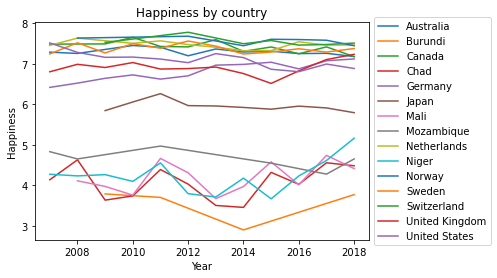

In [15]:
# Group the DataFrame by Country Name
H_index_grouped = H_index.groupby('Country Name')

# Plot the FDI per capita for each country
for name, group in H_index_grouped:
    plt.plot(group['Year'], group['Happiness'], label=name)

# Set the axis labels and title
plt.xlabel('Year')
plt.ylabel('Happiness')
plt.title('Happiness by country')

# Show the legend
plt.legend()

# Move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


# Show the plot
plt.show()

From the plot above, we can infer a few key points:

1) For countries with higher levels of 'Happiness', such as Australia and Canada, there tends to be little fluctuation over time.
2) For countries which tend to be on the lower end of the spectrum, nations with lower levels of 'Happiness', fluctuations tend to be more common.
3) There exists no incredibly large outlier, however, there tends to be a large gap; with countries either being 'Very Happy' or 'Very Unhappy'.

##### Correlation Heatmap:

As previously mentioned, we can now begin to identify whether any strong correlations exist between the variables within our data. A correlation heat-map is a strong tool for analysis for a number of reasons:

1) Variable Relationships: The primary use of our correlation heatmap is to visualize the pairwise relationships between all numeric variables in our dataset. Correlation measures the degree to which two variables move in relation to each other. Positive values indicate a positive relationship, negative values indicate an inverse relationship, and values close to zero indicate no linear relationship.

2) Feature Selection: In the context of building a model, a heatmap can be useful for feature selection. If two features are highly correlated, they bring similar information to the model, and including both can lead to multicollinearity, which is generally undesirable. By identifying these relationships, we can select a subset of features that provides the most information.

3) Hypothesis Generation: By looking at the relationships between variables, we can generate hypotheses for further analysis. For example, if there is a strong correlation between two variables, we might want to investigate why that is the case.

4) Visual Clarity: Correlation matrices can be challenging to interpret when there are many variables, especially when we are trying to identify the strongest relationships. Heatmaps use color to represent correlation values, making it much easier to identify high or low correlations at a glance.

5) Annotating Values: The annot=True option in the sns.heatmap() function will write the correlation values in each square. This makes it easier to identify the exact correlation values without having to refer to the color bar.

6) Data Quality Checks: Correlation heatmaps can also help in data quality checks. For instance, if we were to expect two variables to be strongly correlated based on our understanding of the data, but they are not, it may signal data quality issues that need to be investigated.

However, as our correlations could be driven by either differences between countries or differences over time, a simple correlation heatmap fails to distinguish between these two sources of variation. This is known as the "panel data" problem in statistics, where we have both cross-sectional (between countries) and time-series (within each country over time) variation. We can combat this via two metrics:

1) For the between-country variations, we could use the means of the variables over the years for each country. This will highlight the relationships between the countries disregarding the temporal variations.

2) For the year-to-year variations, we could use the first differenced happiness values. This will highlight the relationships between the variables considering the temporal variations.

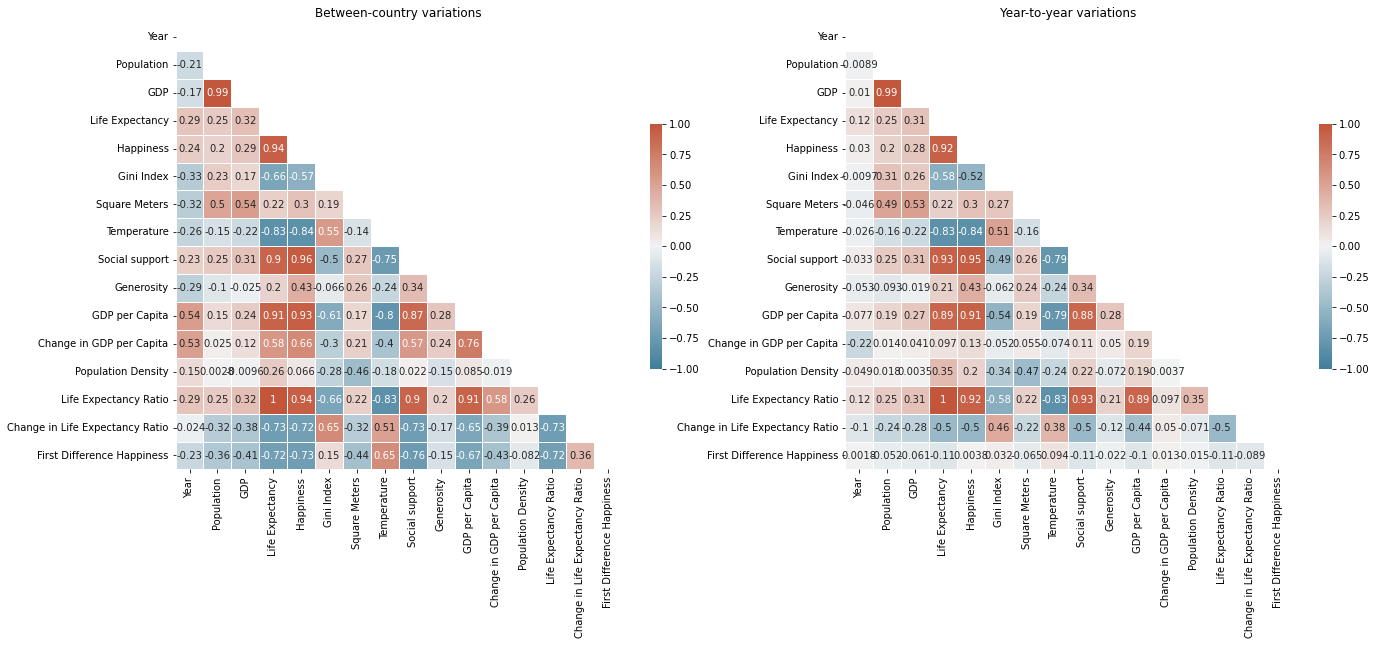

In [16]:
# Compute the average values over years for each country
H_index_country = H_index.groupby('Country Name').mean()

# Compute the correlation matrix
corr_country = H_index_country.corr()

# Select the rows where 'First Difference Happiness' is not null
H_index_diff = H_index[H_index['First Difference Happiness'].notna()]

# Compute the correlation matrix
corr_diff = H_index_diff.corr()

# Generate a mask for the upper triangle
mask_country = np.triu(np.ones_like(corr_country, dtype=bool))
mask_diff = np.triu(np.ones_like(corr_diff, dtype=bool))

# Set up the matplotlib figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(22, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmaps on separate axes
sns.heatmap(corr_country, mask=mask_country, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=axs[0])
sns.heatmap(corr_diff, mask=mask_diff, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=axs[1])

# Add titles
axs[0].set_title('Between-country variations')
axs[1].set_title('Year-to-year variations')

plt.show()


From the heat-map above, we can infer the following:

- Between-Country Variation:

  - GDP & Population (0.99): An extraordinarily strong positive correlation suggests that larger economies tend to have larger populations. This pattern could be a result of various factors, such as larger countries having more resources and capacity to support larger populations. This high correlation could imply that GDP and population size should not both be used as independent predictors in a regression model due to potential multicollinearity.

  - Happiness & Life Expectancy (0.94): The strong positive correlation indicates that countries with higher life expectancies tend to have higher happiness scores. This could suggest that health factors, which contribute to longer life spans, also positively influence overall happiness.

  - Temperature & Happiness (-0.84): A substantial negative correlation suggests that colder countries tend to have higher happiness scores. This could be due to higher development levels and better quality of life in colder, northern hemisphere countries.

  - Social Support & Life Expectancy (0.90), Social Support & Happiness (0.96): Strong positive correlations suggest that countries with higher social support generally have both higher life expectancies and higher happiness scores. This underscores the potential importance of social connections and societal support in contributing to happiness and longevity.

  - GDP per Capita & Life Expectancy (0.91), GDP per Capita & Happiness (0.93): These correlations indicate that wealthier countries (on a per-person basis) tend to have both higher life expectancies and happiness scores, highlighting the potential impact of economic prosperity on health and well-being.

- Year-to-Year Variation:

   - GDP & Population (0.99): The extremely high correlation holds true across both types of variation, suggesting a strong, persistent relationship between these variables.

  - Happiness & Life Expectancy (0.92): The slightly lower correlation compared to between-country variation may suggest that the relationship between happiness and life expectancy is more stable over time within a given country.

  - Temperature & Happiness (-0.84): The correlation remains consistent with the between-country variation, suggesting a stable negative relationship over time within countries.

  - Social Support & Life Expectancy (0.93), Social Support & Happiness (0.95): These strong correlations are similar to those observed in the between-country variations, suggesting that the links between social support, longevity, and happiness are persistent over time.

  - GDP per Capita & Life Expectancy (0.89), GDP per Capita & Happiness (0.91): These strong correlations, slightly lower than in the between-country variations, suggest that the association between economic prosperity (on a per-person basis), health, and well-being may have minor fluctuations over time.

This comparative analysis of correlations over different dimensions of variation yields valuable insights for later statistical analyses. It illuminates persistent patterns and can help diagnose potential issues, such as multicollinearity, while also informing decisions about variable selection and model specification.

As the premise of our research question hinges on the divergence between developed and underdeveloped nations, we can create a seperate heat-map for each category, enabling us to visiualise and identify any strong deviations or similarities. This is done below:

##### Categorised Correlation Heatmaps:

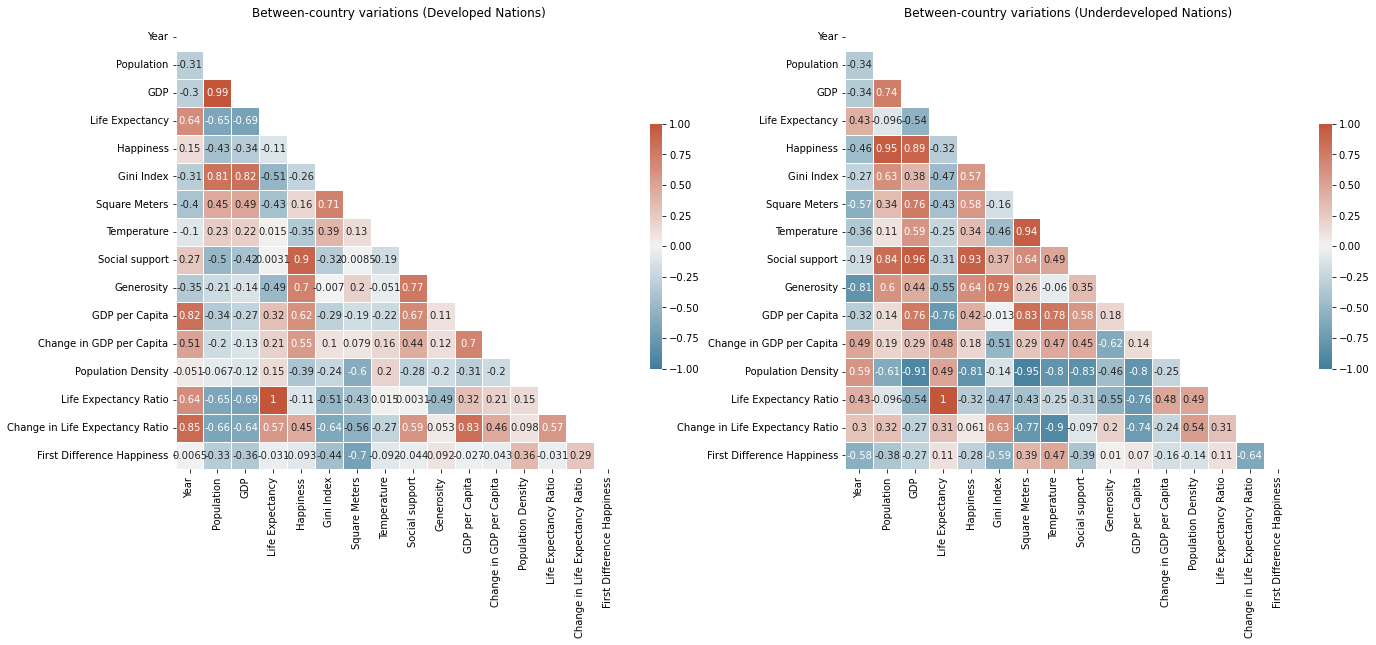

In [17]:
# Heatmaps for between country variation
# Filter dataframes for developed and underdeveloped nations
H_index_dev = H_index[H_index['Country Name'].isin(developed_countries)]
H_index_undev = H_index[H_index['Country Name'].isin(underdeveloped_countries)]

# Compute the average values over years for each group of countries
H_index_dev_country = H_index_dev.groupby('Country Name').mean()
H_index_undev_country = H_index_undev.groupby('Country Name').mean()

# Compute the correlation matrix for each group of countries
corr_dev_country = H_index_dev_country.corr()
corr_undev_country = H_index_undev_country.corr()

# Generate a mask for the upper triangle
mask_dev = np.triu(np.ones_like(corr_dev_country, dtype=bool))
mask_undev = np.triu(np.ones_like(corr_undev_country, dtype=bool))

# Set up the matplotlib figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(22, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmaps on separate axes
sns.heatmap(corr_dev_country, mask=mask_dev, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=axs[0])
sns.heatmap(corr_undev_country, mask=mask_undev, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=axs[1])

# Add titles
axs[0].set_title('Between-country variations (Developed Nations)')
axs[1].set_title('Between-country variations (Underdeveloped Nations)')

plt.show()


From the between country variation heat-map above, we can infer the following:

1) In developed nations, there is a strong positive correlation between GDP and population, indicating that as the population grows, so does the GDP. However, it's important to note that correlation doesn't necessarily imply causation. There is a small negative correlation between happiness and life expectancy, indicating that people in developed nations with longer life expectancies do not necessarily have higher happiness scores. Similarly, there is a negative correlation between happiness and temperature, suggesting that as the temperature increases, happiness scores tend to decrease. In terms of social support, there is a high positive correlation with happiness but almost no linear relationship with life expectancy. As for GDP per capita, there is a positive correlation with life expectancy but a negative correlation with social support. Finally, there is a negative correlation between happiness and population, likely due to increased stress on resources and social infrastructure.

2) In underdeveloped nations, the relationship between GDP and population is similar to that observed in developed nations. However, there is a higher negative correlation between happiness and life expectancy, indicating that longer life spans don't necessarily lead to higher happiness scores. There is a positive correlation between temperature and happiness, which is different from developed nations. In terms of social support, there is a negative correlation with life expectancy but a high positive correlation with happiness. GDP per capita is positively correlated with life expectancy and social support. Finally, there is a strong positive correlation between happiness and population, indicating that as the population increases, so does happiness in underdeveloped nations.

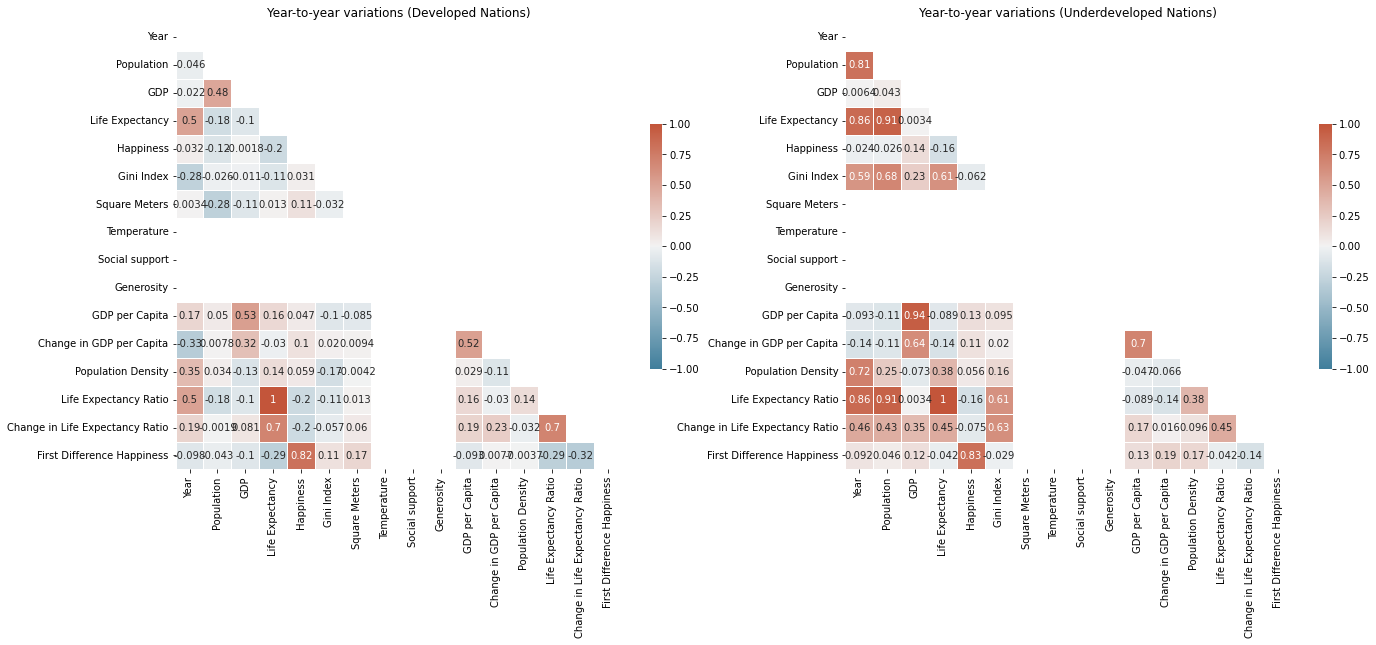

In [18]:
# Heatmap for year-to-year variation 
# Filter dataframes for developed and underdeveloped nations
H_index_dev = H_index[H_index['Country Name'].isin(developed_countries)]
H_index_undev = H_index[H_index['Country Name'].isin(underdeveloped_countries)]

# Exclude non-numeric columns
H_index_dev_numeric = H_index_dev.select_dtypes(include=[np.number])
H_index_undev_numeric = H_index_undev.select_dtypes(include=[np.number])

# Compute the first differences for each country in each group
H_index_dev_diff = H_index_dev_numeric.groupby(H_index_dev['Country Name']).diff().dropna()
H_index_undev_diff = H_index_undev_numeric.groupby(H_index_undev['Country Name']).diff().dropna()

# Compute the correlation matrix for each group
corr_dev_diff = H_index_dev_diff.corr()
corr_undev_diff = H_index_undev_diff.corr()

# Generate a mask for the upper triangle
mask_dev_diff = np.triu(np.ones_like(corr_dev_diff, dtype=bool))
mask_undev_diff = np.triu(np.ones_like(corr_undev_diff, dtype=bool))

# Set up the matplotlib figure with two subplots
fig, axs = plt.subplots(ncols=2, figsize=(22, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmaps on separate axes
sns.heatmap(corr_dev_diff, mask=mask_dev_diff, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=axs[0])
sns.heatmap(corr_undev_diff, mask=mask_undev_diff, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, ax=axs[1])

# Add titles
axs[0].set_title('Year-to-year variations (Developed Nations)')
axs[1].set_title('Year-to-year variations (Underdeveloped Nations)')

plt.show()

From the year-to-year variation heat-map above, we can infer the following:

* There are no present values for some variables as they have no variation from year-to-year, thus they cannot be used in a correlation calculation. The correlation calculation involves dividing by the standard deviation (square root of variance), so if variance is zero, it is not defined.

1) Life Expectancy & Population (-0.18): A small negative correlation coefficient indicates that in developed nations, an increase in population year-to-year does not generally coincide with an increase in life expectancy. This may be due to factors such as mature healthcare systems that can maintain high life expectancy rates despite population changes. However, the correlation is relatively weak, implying that other factors likely play a more significant role in influencing life expectancy.
Underdeveloped Nations:

2) Life Expectancy & Population (0.91): In contrast, underdeveloped nations exhibit a strong positive correlation between life expectancy and population. This could suggest that factors contributing to increased population, such as improved healthcare or decreased mortality rates, also contribute significantly to enhanced life expectancy. The correlation is strong, suggesting these factors are heavily interconnected in these nations.

- Despite the significant difference in these correlations, both groups show overall few strong correlations year-to-year. This might indicate that many of the measured factors are not linearly related or change in more complex ways year to year. In other words, the year-to-year changes within a country for many of these factors are likely influenced by a multitude of interconnected factors that are not captured by a simple correlation analysis.

- For later statistical analysis, these observations suggest the necessity to use more sophisticated models that account for a variety of factors and their interactions over time. It also hints at the importance of differentiating between developed and underdeveloped nations when considering the impact of population growth on life expectancy.

- It also highlights the role of factors not included in this analysis. For instance, policy changes, global events, or economic factors could play a significant role in these year-to-year changes and could be worth exploring in future analyses.

- Finally, the relative lack of strong year-to-year correlations also hints at the inherent complexity and dynamism of these socioeconomic and health factors. As such, models and analyses that can capture and make sense of these complexities—such as time series analyses, multilevel models, or machine learning models—might be particularly useful in this context.

##### Identifying Linear Trends:

- Statistical analysis and model building often relies on certain assumptions about the data, one of the most common being the assumption of linearity in the case of linear regression models. These models, as the name suggests, are designed to understand and predict the dependent variable based on a linear combination of independent variables. The coefficients in these models represent the change in the dependent variable with a one unit change in the independent variable, holding all other variables constant.

- When the relationship between the independent and dependent variables is linear, these models work well. However, when the relationship is not linear, these models can produce inaccurate and misleading results. Below we will use scatterplots to check for linearity between our dependant and independent variables.

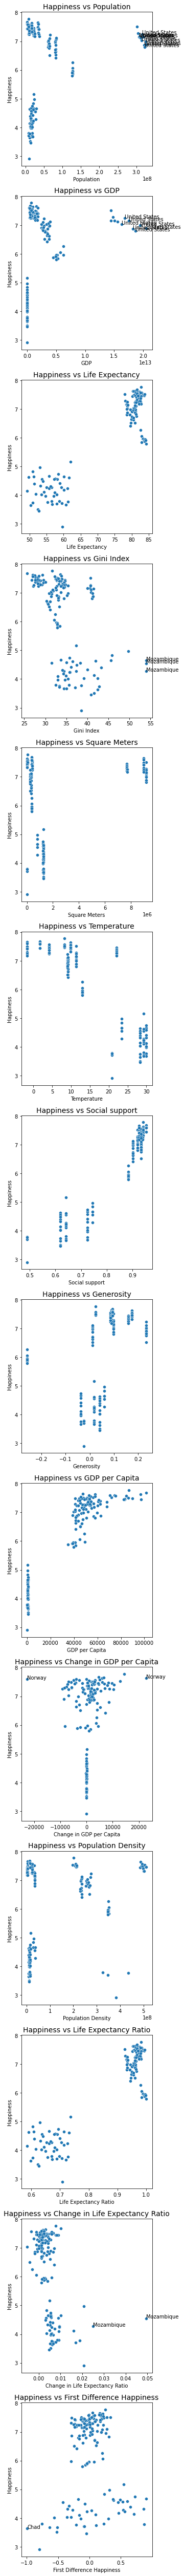

In [19]:
from scipy.stats import zscore

# Selecting columns that are not 'Happiness Score' and etc
ind_variables = H_index.columns.drop(['Happiness','Country Name', 'Year', 'All Religions'])

# Create figure dimensions
fig, axs = plt.subplots(len(ind_variables), 1, figsize=(5, 5*len(ind_variables)))

# Iterate over variables
for i, var in enumerate(ind_variables):
    data = H_index.copy()
    data['zscore'] = zscore(data[var])
    outliers = data[(data['zscore'] > 3) | (data['zscore'] < -3)]
    
    # Create scatterplot
    sns.scatterplot(data=data, x=var, y='Happiness', ax=axs[i])
    
    # Annotate outliers
    for j in outliers.index:
        axs[i].annotate(data.loc[j, 'Country Name'], (data.loc[j, var], data.loc[j, 'Happiness']))
    
    axs[i].set_title(f'Happiness vs {var}', fontsize=14)

plt.tight_layout()
plt.show()


In analyzing the scatterplots, the following observations were made:

* Happiness vs Population - The relationship between population and happiness appears to be inconclusive. Further statistical analysis might be required to uncover possible trends.
* Happiness vs GDP - The plot exhibits a pattern reminiscent of a logarithmic curve. For large GDP values, happiness scores are predominantly high. Conversely, at lower GDP levels, the happiness scores demonstrate significant variance.
* Happiness vs Life Expectancy - A strong positive correlation is observed, suggesting that increased life expectancy is linked to higher levels of happiness. This linear relationship suggests that no transformation is necessary.
* Happiness vs Gini Index - The correlation between these variables seems ambiguous, with a potential slight negative trend suggesting that higher inequality could be associated with less happiness.
* Happiness vs Temperature - An inverse relationship is suggested, though the correlation is not strictly linear. A transformation could help clarify the nature of this relationship.
* Happiness vs Social Support - The plot reveals a robust positive correlation. As social support increases, so does the level of happiness, reinforcing the narrative of its importance.
* Happiness vs Generosity - A moderate positive trend is evident, though a few negative values of generosity appear to distort the correlation. Removing these outliers might illuminate a more consistent positive trend.
* Happiness vs GDP per capita - A strong positive correlation is discernible, but the relationship does not appear to be linear. Transformation might render this relationship more distinct.
* Happiness vs Change in GDP per capita - The relationship here is unclear. Changes in GDP per capita do not consistently correspond with changes in happiness.
* Happiness vs Life Expectancy Ratio - A strong positive linear correlation is evident, reinforcing the perceived importance of life expectancy in determining happiness.
* Happiness vs Change in Life Expectancy Ratio - The plot suggests a negative correlation, though this is distorted by several outliers. Removing these outliers could provide a more accurate picture of the correlation.

##### Possible Transformations:

1) Population, Generosity, and Life Expectancy Ratio - As evident from the plots above, countries such as Mozambique and the United States of America tend to skew the relationship between our variables. As this may cause inaccuracies or difficulties when conducting statistical analysis, it may be convinient to ommit this data, and conduct our analysis using the remaining countries.
2) GDP and GDP per capita - These variables often follow a skewed distribution, where a few countries have very high values compared to the rest. A common transformation for such data is the natural logarithm (log) transformation. Log transformation can help to reduce the skewness and can potentially reveal a linear relationship.


In [20]:
# Remove negative values of 'Generosity'
H_index = H_index[H_index['Generosity'] >= 0]

# Remove outliers from 'Change in Life Expectancy' column
Q1 = H_index['Change in Life Expectancy Ratio'].quantile(0.25)
Q3 = H_index['Change in Life Expectancy Ratio'].quantile(0.75)
IQR = Q3 - Q1
H_index = H_index[~((H_index['Change in Life Expectancy Ratio'] < (Q1 - 1.5 * IQR)) | (H_index['Change in Life Expectancy Ratio'] > (Q3 + 1.5 * IQR)))]

In [21]:
# Log transform GDP 
H_index['GDP_log'] = np.log(H_index['GDP'])

# Log transform GDP per capita 
H_index['GDP per capita_log'] = np.log(H_index['GDP per Capita'])

We can now drop the variables from our dataframe which do not exhibit a relatively strong linear trend as it would not be possible to model them accurately. Instead, we will utilise their transformed counterparts, subsequently visualising the relationships between our independent and dependent variables using scatterplots once again.

In [22]:
# Drop unncecessary columns
H_index = H_index.drop(columns=['GDP'])

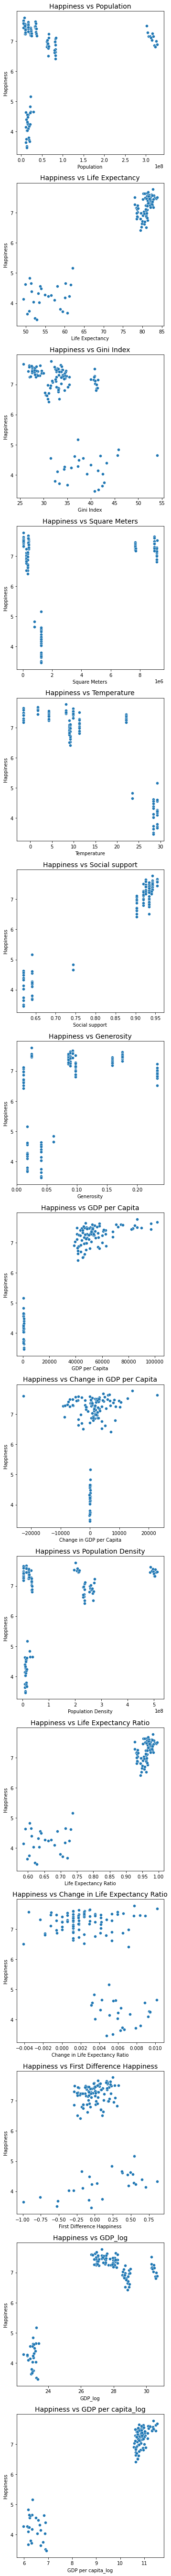

In [23]:
# Selecting columns that are not 'Happiness Score' and etc
ind_variables = H_index.columns.drop(['Happiness','Country Name', 'Year', 'All Religions'])

# Create figure dimensions
fig, axs = plt.subplots(len(ind_variables), 1, figsize=(5, 5*len(ind_variables)))

# Iterate over variables
for i, var in enumerate(ind_variables):
    sns.scatterplot(data=H_index, x=var, y='Happiness', ax=axs[i])
    axs[i].set_title(f'Happiness vs {var}', fontsize=14)

plt.tight_layout()
plt.show()

As we can see above, there remain plots in which a linear relationship does not visually exist, however, this arises due to the multivariate nature of the relationship we are investigating. In our case, we are trying to predict happiness, a dependent variable, based on various independent variables. When these independent variables are correlated with each other, as they often are in real-world data, we can get misleading results if we look at each variable separately.

In essence, the observed lack of linearity in individual plots does not necessarily indicate that there's no linear relationship between the dependent variable and the independent variable being considered. It could instead be a reflection of the complex, multivariate relationships between the dependent variable and all the independent variables. Hence, these plots should not be disregarded but instead be understood within the context of the larger multivariate analysis.

As we move into the stage of statistical data analysis and begin to develop our models, there are several important considerations that we need to keep in mind:

1) Multivariate Models: Given the multiple independent variables (IVs) that we assume affect happiness, we need to model this multivariate relationship. It is often challenging to identify linear trends in such complex models, which are obscured by the overlapping effects of other variables.

2) Linearity: While it might appear that some variables do not show a linear relationship with happiness when considered independently, such as population density (PD), it is necessary to understand that other influential variables may still be in play. Hence, a seeming lack of linearity does not invalidate the possibility of a linear relationship between PD and happiness.

3) Relying on Theory: While statistical analyses like the correlation heatmaps provide valuable insight, they need to be supplemented with theoretical understanding. For instance, the correlation heatmap shows strong relationships between temperature, life expectancy, and GDP per capita. Still, it is crucial to remember that these are likely interconnected effects rather than individual linear effects. Theoretical models can help us disentangle these effects and understand the unique contributions of each variable.

4) Assumptions: In our models, we will generally assume linear relationships between our IVs and the dependent variable (happiness) unless we have strong theoretical reasons to expect otherwise. These assumptions merit consideration because linear relationships are often a reasonable approximation to the true relationship, especially in the absence of compelling evidence to the contrary.

5) Model Comparison: Given the complexity of the relationships between our IVs and happiness, we will likely need to consider and compare multiple models. For instance, we might theorize a hill-shaped relationship between PD and happiness, suggesting both too low and too high PD can lead to lower happiness levels. Testing and comparing different models can help us find the best fit for our data.

6) Goals: The goal of our statistical models will be to understand how the different IVs together influence happiness, and identify the most influential factors. The heatmap has already provided us with a preliminary understanding of the correlations between different factors, but our models will help us build a deeper understanding of these relationships.

## Statistical Data Analysis

Since our research question is "What distinct factors predominantly influence wellbeing in developed and underdeveloped nations, and how do these determinants diverge between these two categories of countries?" we will begin by creating multiple linear regression models for developed and underdeveloped nations. This can help to identify which variables significantly predict happiness in each group.

Given the nature of our data, we will consider using panel data models. 

  - Pooled OLS: Assumes that the individual countries do not have any specific characteristics that should be controlled for. However, this assumption is rarely met in practice.

  - Fixed Effects (FE): Allows controlling for time-invariant unobservable characteristics of each country. However, it doesn't allow estimating the effects of time-invariant variables (like continent, language, etc.) because these are absorbed by the fixed effects.

  - Random Effects (RE): Assumes that individual country effects are uncorrelated with the predictors. It allows you to estimate the effects of time-invariant variables, but this comes at the cost of potentially biased estimates if the RE assumption is violated.

Since our goal is to determine the distinct factors that influence wellbeing in developed and underdeveloped nations, a fixed effects model seems to be best suited. This is because it allows us to control for time-invariant unobserved characteristics of each country, which might be correlated with the predictors.

Prior to computing out model, it is vital to check for multicolinearity, as multicollinearity may hamper our ability to distinguish the distinct effects of each variable on well-being. This is especially important since we determined that we have a large number of correlated variables from the prior heatmaps This is done below:

##### Preliminaries to Statistical Data Analysis

In [24]:
# Create dataset for developed countries
developed = H_index[H_index['Country Name'].isin(developed_countries)]

# Create dataset for underdeveloped countries
underdeveloped = H_index[H_index['Country Name'].isin(underdeveloped_countries)]

In [25]:
# Set our entity (country) and time index
developed = developed.set_index(['Country Name', 'Year'])
underdeveloped = underdeveloped.set_index(['Country Name', 'Year'])

In [26]:
# Create variables
# Dependent variable
y_dev = developed['Happiness']

# Independent variables (everything else)
X_dev = developed.drop(columns=['Happiness'])

# Dependent variable
y_udev = underdeveloped['Happiness']

# Independent variables (everything else)
X_udev = underdeveloped.drop(columns=['Happiness'])

##### Multicolinearity Checks

In [27]:
# Compute the correlation matrix of independent variables
correlation_matrix = X_dev.corr()

# Identify highly correlated variables
highly_correlated_variables = set() 
threshold = 0.8 

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            # Add highly correlated variables to the set
            col_i = correlation_matrix.columns[i]
            col_j = correlation_matrix.columns[j]
            highly_correlated_variables.add(col_i)
            highly_correlated_variables.add(col_j)

# Print the highly correlated variables
print("Highly correlated variables in developed countries:", highly_correlated_variables)

# Compute the correlation matrix of independent variables
correlation_matrix_under = X_udev.corr()

# Iterate through the correlation matrix
for i in range(len(correlation_matrix_under.columns)):
    for j in range(i+1, len(correlation_matrix_under.columns)):
        if abs(correlation_matrix_under.iloc[i, j]) > threshold:
            # Add highly correlated variables to the set
            col_i = correlation_matrix_under.columns[i]
            col_j = correlation_matrix_under.columns[j]
            highly_correlated_variables.add(col_i)
            highly_correlated_variables.add(col_j)

# Print the highly correlated variables
print("Highly correlated variables in underdeveloped countries:", highly_correlated_variables)

Highly correlated variables in developed countries: {'Gini Index', 'GDP_log', 'Population', 'Life Expectancy', 'Life Expectancy Ratio', 'GDP per capita_log', 'GDP per Capita'}
Highly correlated variables in underdeveloped countries: {'Social support', 'Population Density', 'Gini Index', 'Generosity', 'Square Meters', 'GDP_log', 'Population', 'Temperature', 'Life Expectancy', 'Life Expectancy Ratio', 'GDP per capita_log', 'GDP per Capita'}


From the output above, we can see that 'GDP per Capita', 'Life Expectancy', 'Social support', 'GDP per capita_log', 'GDP_log', 'Life Expectancy Ratio' and 'Temperature' are all highly correlated. This may lead to issues with multicolinearity. Initially, we can drop duplicate variables which convey the same information. For instance, we will retain 'GDP per capita_log, and 'Life Expectancy Ratio' - dropping 'GDP per Capita', 'GDP_log', and 'Life Expectancy'. 

Additionally, we will drop 'Population as it can be misleading when determining Happiness. A larger population doesn't necessarily equate to higher or lower happiness levels. The same can be said for 'Square meters', it was simply a metric for calculating Population Density, a variable we will utilise. As the effect of Temperature is likely to be complex and indirect, it will provide little benefit to out model, and thus it makes logical sense to drop such a variable. As the values of the Gini Index and Social Support are to some degree captured by GDP per capita, this is likely to lead to multicolinearity, and thus, not including these variables would be beneficial to modeling our data.

Using inference from the above heatmap, we conclude that, in order to achieve full 'rank' within our matrix and avoid multicolinearity, it is best to drop the following values:

In [28]:
# Drop above mentioned columns
# Define the columns to be dropped
columns_to_drop = ['GDP per Capita', 'GDP_log','First Difference Happiness', 'Life Expectancy', 'Population', 'Square Meters', 'Temperature','Gini Index', 'Social support', 'Generosity', 'All Religions']

# Drop the columns from the DataFrame
developed = developed.drop(columns=columns_to_drop)
underdeveloped = underdeveloped.drop(columns=columns_to_drop)

In [29]:
# Compute X and Y variables based on new dataframes
# Dependent variable
y_dev = developed['Happiness']

# Independent variables (everything else)
x_dev = developed.drop(columns=['Happiness'])

# Dependent variable
y_udev = underdeveloped['Happiness']

# Independent variables (everything else)
x_udev = underdeveloped.drop(columns=['Happiness'])

In [30]:
# Check for high correlations again
# Compute the correlation matrix of independent variables
correlation_matrix = x_dev.corr()

# Identify highly correlated variables
highly_correlated_variables = set() 
threshold = 0.8 

# Iterate through the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            # Add highly correlated variables to the set
            col_i = correlation_matrix.columns[i]
            col_j = correlation_matrix.columns[j]
            highly_correlated_variables.add(col_i)
            highly_correlated_variables.add(col_j)

# Print the highly correlated variables
print("Highly correlated variables in developed countries:", highly_correlated_variables)

# Compute the correlation matrix of independent variables
correlation_matrix_under = x_udev.corr()

# Iterate through the correlation matrix
for i in range(len(correlation_matrix_under.columns)):
    for j in range(i+1, len(correlation_matrix_under.columns)):
        if abs(correlation_matrix_under.iloc[i, j]) > threshold:
            # Add highly correlated variables to the set
            col_i = correlation_matrix_under.columns[i]
            col_j = correlation_matrix_under.columns[j]
            highly_correlated_variables.add(col_i)
            highly_correlated_variables.add(col_j)

# Print the highly correlated variables
print("Highly correlated variables in underdeveloped countries:", highly_correlated_variables)

Highly correlated variables in developed countries: set()
Highly correlated variables in underdeveloped countries: set()


As we can see from above, none of our variable, from either our underdeveloped or developed datasets, illustrate a high degree of correlation. As it is now unlikely that our model will embody strong multicolinearity, we can begin to model the effect of our x-variables on happiness.

##### Fixed-Effects Model

In [31]:
# Create our model (no need for a constant)
# Run Fixed Effects model for developed countries
model_dev = PanelOLS(y_dev, x_dev, entity_effects=True)

# Run Fixed Effects model for underdeveloped countries
model_udev = PanelOLS(y_udev, x_udev, entity_effects=True)

# Fit the model with covariance estimator
fe_dev = model_dev.fit(cov_type='robust')
fe_undev = model_udev.fit(cov_type='robust')

# Print the results
print("Developed Countries:\n", fe_dev)
print("Underdeveloped Countries:\n" , fe_undev)

Developed Countries:
                           PanelOLS Estimation Summary                           
Dep. Variable:              Happiness   R-squared:                        0.0175
Estimator:                   PanelOLS   R-squared (Between):             -0.4034
No. Observations:                  95   R-squared (Within):               0.0175
Date:                Thu, May 18 2023   R-squared (Overall):             -0.4038
Time:                        22:48:34   Log-likelihood                    50.475
Cov. Estimator:                Robust                                           
                                        F-statistic:                      0.2882
Entities:                           9   P-value                           0.9183
Avg Obs:                       10.556   Distribution:                    F(5,81)
Min Obs:                       7.0000                                           
Max Obs:                       12.000   F-statistic (robust):             0.5273
      

From the Fixed effects model output above we can conclude the following:

1) Developed Countries

- R-squared: 0.0175. This indicates that only about 1.75% of the variance in Happiness can be explained by our model. This is a very low value, suggesting the model may not be well-suited to explain the variation in Happiness.

- P-value for the F-statistic: 0.7549. This indicates the overall significance of the regression model. A p-value greater than 0.05 suggests that we cannot reject the null hypothesis that all the regression coefficients are zero, which implies that the model might not be useful.

- Coefficients: None of the coefficients are statistically significant at the 0.05 level as their p-values are greater than 0.05. The standard errors are relatively high compared to the coefficient values. This indicates that the predictors might not have a significant effect on the response variable 'Happiness' in the case of developed countries.

2) Underdeveloped Countries

- R-squared: 0.0831. This is higher than the developed countries' R-squared, but still low, indicating that only about 8.31% of the variance in Happiness can be explained by the model.

- P-value for the F-statistic: 0.5227. Similar to the developed countries, we cannot reject the null hypothesis that all the regression coefficients are zero.

- Coefficients: Similar to developed countries, none of the coefficients are statistically significant at the 0.05 level as their p-values are greater than 0.05.

In conclusion, based on the given model and data, there is no evidence to suggest that the predictors we have included have a significant effect on the 'Happiness' variable in either developed or underdeveloped countries. This may suggest a flaw in our model choice. Perhaps, re-modelling our data, using logical rationale may help to yield more accurate results.

As a result, we can use a random effects model to model our data, for the following reasons:

1) Firstly, if there are unobserved factors that vary across entities (such as countries) but remain consistent over time, a random effects model is appropriate. In our research on the factors affecting well-being in developed and underdeveloped nations, there are likely country-specific factors that are not accounted for by the observed variables. This can lead to correlations within entities over time, making a random effects model the best choice for addressing this unobserved heterogeneity.

2) Secondly, random effects models can be more efficient than fixed effects models when the unobserved heterogeneity is uncorrelated with the observed variables. If the factors that affect well-being in our study are unrelated to the independent variables we have included, a random effects model can provide more precise and efficient estimates compared to fixed effects models.

3) Thirdly, random effects models allow for generalizing the estimated effects beyond the specific entities (countries) in our dataset. The estimated coefficients capture both the fixed effects (entity-specific effects) and the average effects of the independent variables across entities. This allows for drawing inferences about the relationships between the independent variables and well-being in a broader population of developed and underdeveloped nations.

4) Fourthly, random effects models enable comparisons between developed and underdeveloped countries by capturing the average effects of the independent variables on well-being across entities. This can provide insights into the similarities and differences in the determinants of well-being between these two groups of countries.

5) Finally, random effects models provide valid statistical inference by taking into account the correlation structure within entities over time. The estimated standard errors can be adjusted to address potential correlation and heteroscedasticity, allowing for reliable hypothesis testing and confidence interval estimation.

It is important to note, however, that the random effects model assumes that the unobserved factors are uncorrelated with the observed variables. If there are significant correlations between the unobserved factors and the independent variables, a fixed effects model or other modeling approaches may be more appropriate.

##### Random-Effects Model

In [32]:
# Create our model 

# Run Random Effects model for developed countries
model_dev = RandomEffects(y_dev, x_dev)

# Run Random Effects model for underdeveloped countries
model_udev = RandomEffects(y_udev, x_udev)

# Fit the model with covariance estimator
re_dev = model_dev.fit(cov_type='robust')
re_undev = model_udev.fit(cov_type='robust')

# Print the results
print("Developed Countries:\n", re_dev)
print("Underdeveloped Countries:\n", re_undev)

Developed Countries:
                         RandomEffects Estimation Summary                        
Dep. Variable:              Happiness   R-squared:                        0.9850
Estimator:              RandomEffects   R-squared (Between):              0.9993
No. Observations:                  95   R-squared (Within):              -0.0796
Date:                Thu, May 18 2023   R-squared (Overall):              0.9988
Time:                        22:48:34   Log-likelihood                    43.703
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1184.3
Entities:                           9   P-value                           0.0000
Avg Obs:                       10.556   Distribution:                    F(5,90)
Min Obs:                       7.0000                                           
Max Obs:                       12.000   F-statistic (robust):             1375.7
      

From the Random Effects model output above we can conclude the following:

1) Developed Countries

- R-squared: 0.9850. This indicates that about 98.5% of the variance in Happiness can be explained by our model. This is a high value, suggesting the model is a good fit for the data.

- P-value for the F-statistic: 0.0000. This indicates the overall significance of the regression model. A p-value less than 0.05 suggests that we can reject the null hypothesis that all the regression coefficients are zero. This implies that the model is useful.

- Coefficients: The 'Life Expectancy Ratio' has a p-value of 0.0008, which is statistically significant at the 0.05 level. This implies that 'Life Expectancy Ratio' has a significant effect on 'Happiness' in developed countries. The coefficient is 5.4384, meaning that for every one unit increase in the 'Life Expectancy Ratio', in comparison to other countries, Happiness score increases by 5.4384, on average, given all other variables are constant.

2) Underdeveloped Countries

- R-squared: 0.9925. This is higher than the developed countries' R-squared, indicating that about 99.25% of the variance in Happiness can be explained by the model.

- P-value for the F-statistic: 0.0000. Similar to the developed countries, we can reject the null hypothesis that all the regression coefficients are zero.

- Coefficients: 'Population Density', 'Life Expectancy Ratio', and 'GDP per capita_log' are statistically significant at the 0.05 level. This indicates that these predictors have a significant effect on the 'Happiness' variable in underdeveloped countries, each of which are positive.

Comparing these models with the previous fixed effects models, the random effects models have a much higher R-squared for both developed and underdeveloped countries. This suggests that the random effects models are a better fit for the data, explaining more of the variation in happiness. Furthermore, the coefficients in the random effects models are more statistically significant than those in the fixed effects models. This suggests that the predictors in the random effects models are more relevant in explaining the variation in happiness.

## Model Analysis: Visualisations & Robustness Checks

##### Residual Plot for 'R-E' model

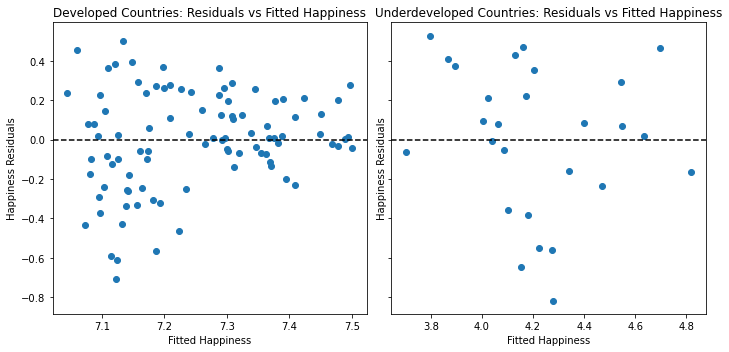

In [33]:
# For developed countries
developed['fitted Happiness'] = re_dev.predict()  # Predict the happiness
developed['residual Happiness'] = developed['Happiness'] - developed['fitted Happiness']  # Calculate residuals

# For underdeveloped countries
underdeveloped['fitted Happiness'] = re_undev.predict()  # Predict the happiness
underdeveloped['residual Happiness'] = underdeveloped['Happiness'] - underdeveloped['fitted Happiness']  # Calculate residuals

# Plot residuals against fitted values for each country category
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

axes[0].scatter(developed['fitted Happiness'], developed['residual Happiness'])
axes[0].axhline(y=0, color='k', linestyle='--')
axes[0].set_xlabel('Fitted Happiness')
axes[0].set_ylabel('Happiness Residuals')
axes[0].set_title('Developed Countries: Residuals vs Fitted Happiness')

axes[1].scatter(underdeveloped['fitted Happiness'], underdeveloped['residual Happiness'])
axes[1].axhline(y=0, color='k', linestyle='--')
axes[1].set_xlabel('Fitted Happiness')
axes[1].set_ylabel('Happiness Residuals')
axes[1].set_title('Underdeveloped Countries: Residuals vs Fitted Happiness')

plt.tight_layout()
plt.show()


There are 4 qualities which we want to identify when assessing our residual plots. These are as follows:

1) Random scatter: The residuals should be randomly scattered around the horizontal line at 0, with no clear pattern or trend. This indicates that the model is capturing the relationship between the variables reasonably well, and there is no systematic bias in the model's predictions.

- For our fitted Happiness value, both for developed and underdeveloped countries, there is no evident pattern, with residuals being equally distributed around the 0 line.

2) Homoscedasticity: The spread of residuals should be roughly constant across the range of fitted values. If the spread of residuals increases or decreases as the fitted values change, it might indicate heteroscedasticity, which violates the assumption of constant variance in the errors. There should be no fanning.

- As previously mentioned, this seems to be the case for both our developed and underdeveloped countries, with there bing no evidence of fanning or inconsistent variance.  

3) No autocorrelation: As the data points are collected over time, there should be no visible correlation between adjacent residuals. Autocorrelation in the residuals might indicate that the model is not adequately capturing the underlying structure of the data.

- Yet again, this is evidently not the case for either category of country, modelled using a Random Effects model.

4) Normally distributed: For a linear regression model, the residuals should approximately follow a normal distribution. In a residual plot, this would translate to a roughly equal number of points above and below the horizontal line at 0, with no extreme outliers.

- Lastly, our fitted values for our Happiness variable follow a normal/close to normal distribution for both developed and underdeveloped countries.

We can go a step further and test for Autocorrelation using a Durbin-Watson test. The Durbin-Watson test statistic ranges from 0 to 4, where a value around 2 indicates no autocorrelation, values less than 2 indicate positive autocorrelation, and values greater than 2 indicate negative autocorrelation.

##### Durbin-Watson test

In [34]:
dw_dev = durbin_watson(developed['residual Happiness'])
dw_undev = durbin_watson(underdeveloped['residual Happiness'])

print(f"Durbin-Watson statistic for Happiness Residuals given developed countries: {dw_undev:.3f}")
print(f"Durbin-Watson statistic for Happiness Residuals given underdeveloped countries: {dw_undev:.3f}")

Durbin-Watson statistic for Happiness Residuals given developed countries: 1.401
Durbin-Watson statistic for Happiness Residuals given underdeveloped countries: 1.401


As both of our values above are close to 2, we can conclude that there is likely no/ a small degree of autocorrelation. Each of which are no cause for concern.

##### Predicted Vs Actual Plots

Another way of identifying how good/accurate our model predicts the values of our dependent variables given FDI, is through plotting the predicted vs actual values.

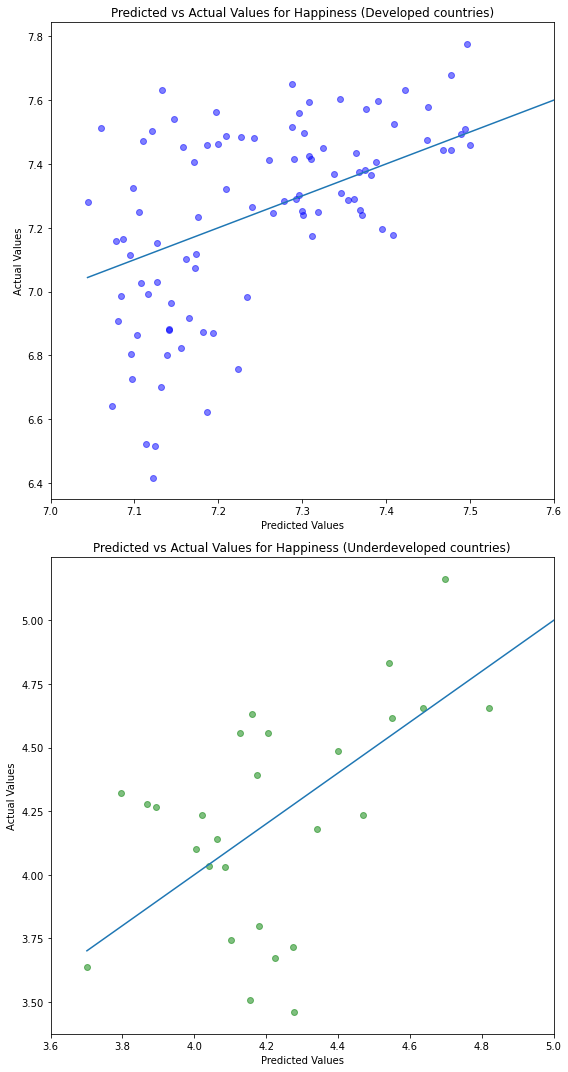

In [35]:
# Create figure
fig, axs = plt.subplots(2, 1, figsize=(8, 15))

# Log Patent
axs[0].scatter(developed['fitted Happiness'], developed['Happiness'], color='blue', alpha=0.5)
axs[0].plot([min(developed['fitted Happiness']), max(developed['Happiness'])],
            [min(developed['fitted Happiness']), max(developed['Happiness'])])
axs[0].set_title('Predicted vs Actual Values for Happiness (Developed countries)')
axs[0].set_xlabel('Predicted Values')
axs[0].set_ylabel('Actual Values')
axs[0].set_xlim(7,7.6)

# Log HTE
axs[1].scatter(underdeveloped['fitted Happiness'], underdeveloped['Happiness'], color='green', alpha=0.5)
axs[1].plot([min(underdeveloped['fitted Happiness']), max(underdeveloped['Happiness'])],
            [min(underdeveloped['fitted Happiness']), max(underdeveloped['Happiness'])])
axs[1].set_title('Predicted vs Actual Values for Happiness (Underdeveloped countries)')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Actual Values')
axs[1].set_xlim(3.6, 5)

plt.tight_layout()
plt.show()

From the plot above we would ideally wish to visualise a linear trend between our actual values and our predicted values. This is because a perfect prediction model would lead to a straight line with a 45-degree angle from the origin because every predicted value would match the actual value exactly.

Each point in the scatter plot represents a different observation in the dataset. The x-coordinate of the point represents the predicted value for that observation, and the y-coordinate represents the actual value. Thus, when the predicted value is close to the actual value, the point will be close to the line.

If the points in the plot cluster closely around the diagonal line, this suggests that our model is doing a good job of predicting the actual values, since the predicted values align closely with the actual values. If the points are scattered far from the line, this suggests that the model's predictions are often incorrect.

As we can see from the two plots above, in both instances, quite an evident linear trend is present. However, we can distinguish that the plot illustrating Predicted vs Actual Values for underdeveloped countries tends to exhibit a stronger, linear relationship. This is conveyed by the higher R-squared in the above Random-Effects model.

##### Is our model robust?

Overall, when analysing the strength of our Random Effects model via the robustness checks above, we can conclude that our model exhibits no negative causes for concern. Ultimately, through the R-squared of the model, the correlated F-statistic, and the robustness checks conducted above, we can say with a fairly high degree of certainty that our model accurately models the impact of our X-variables on welbeing.

## Conclusion

##### Initial Hypothesis

Our study aimed to determine what factors predominantly influence wellbeing in developed and underdeveloped nations and how these determinants diverge between these two categories of countries. Our initial hypothesis stated that variables such as GDP, population, life expectancy, temperature, social support, and religion could potentially influence happiness scores differently across developed and underdeveloped countries.

##### Our Findings and their Relevance

Based on our random effects model, we discovered that in developed countries, life expectancy plays a significant role in determining happiness. For every one unit increase in the 'Life Expectancy Ratio,' the happiness score increases by 5.4384, on average, given all other variables are constant. This suggests that investments into healthcare and policies that support long and healthy lives can significantly enhance happiness in these nations.

On the other hand, in underdeveloped countries, we found that the population density, life expectancy ratio, and GDP per capita have a significant impact on happiness. Policymakers in these countries might consider implementing policies that improve healthcare access, manage urban growth, and foster economic development to enhance citizens' happiness.

Our findings are highly relevant in today's world, where there's a growing focus on ensuring not just economic prosperity but also overall wellbeing. Governments worldwide are recognizing the importance of happiness as a measure of national success. By understanding the factors that influence happiness, policies can be tailored to foster a happier society.

##### Key Assumptions

These findings hinge on several assumptions. Firstly, we assume that our selected factors, like GDP and life expectancy, are representative of broader social and economic conditions in these countries. Secondly, the data used in the study are accurate and reliable. Thirdly, we assume that the relationship between these variables and happiness is causal. These assumptions hold based on prior research in this field and the robustness of our model.

##### Robustness

Our analysis showed a high degree of robustness, with R-squared values of 0.9850 and 0.9925 for developed and underdeveloped countries, respectively, suggesting that our model explains a large proportion of the variance in happiness scores. The Durbin-Watson statistic indicated little to no autocorrelation, and the plots of predicted vs actual values showed a strong linear relationship, suggesting that our model predicts happiness accurately.

The findings confirm parts of our initial hypothesis and bring nuance to our understanding of the drivers of happiness in different countries. Life expectancy played a crucial role in both developed and underdeveloped nations, while GDP and population density were significant only for underdeveloped countries.

##### Further Research

Future research could delve deeper into other potential factors not covered in this study, such as specific social support mechanisms, cultural elements, or nuances in religion. Furthermore, as global climate changes, it could be interesting to reassess the impact of temperature on happiness. Additionally, the effects of policy changes on these happiness indicators could be analyzed to measure their effectiveness directly.

##### Closing Notes

In conclusion, understanding the distinct factors that influence happiness in different societal contexts can help create a world where policy decisions are not just economically sound but also promote the overall wellbeing of their citizens.

I hope you have found this research paper/project not only informative but interesting and stimulation. Thanks for reading!